## Module 6 Practice - Projections and Vector Maps


In this notebook, we will see how to **draw vector maps from different sources.** 

In [2]:
# Useful libraries to visualize maps 
library(ggplot2)
library(sp)
library(maps)
library(maptools)
library(mapproj)
library(mapdata)

Checking rgeos availability: TRUE


**Let's start with plain R to draw flights in between cities.** 

Plain R can be sometimes shorter to code. In this example, our data set has **two files**; 
 - flight information for airlines between airports, 
 - geo coordinates of the airports. 
 
 First, we will go through the flight data and **find out the coordinates of the originating and destination airports and visualize the number of flights**. 

In [3]:
# airport codes and coordinates 
airports <- read.csv("/dsa/data/all_datasets/spatial/airports.csv", as.is=TRUE, header=TRUE)
# flight destinations and counts 
flights <- read.csv("/dsa/data/all_datasets/spatial/flights.csv", as.is=TRUE, header=TRUE)

airports$lat <- as.numeric(airports$lat)
airports$long <- as.numeric(airports$long)

# Look at the data frames 
head(airports)
head(flights)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

iata,airport,city,state,country,lat,long
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
00M,Thigpen,Bay Springs,MS,USA,31.95376,-89.23450
00R,Livingston Municipal,Livingston,TX,USA,30.68586,-95.01793
00V,Meadow Lake,Colorado Springs,CO,USA,38.94575,-104.56989
01G,Perry-Warsaw,Perry,NY,USA,42.74135,-78.05208
01J,Hilliard Airpark,Hilliard,FL,USA,30.68801,-81.90594
01M,Tishomingo County,Belmont,MS,USA,34.49167,-88.20111


airline,airport1,airport2,cnt
<chr>,<chr>,<chr>,<int>
AA,DFW,SJU,120
AA,MSP,DFW,326
AA,LGA,ORD,860
AA,TPA,JFK,56
AA,STT,BOS,44
AA,PHX,DFW,550


The following code draws a world map in plain R using the `map()` function and draws flight paths on it in a loop.

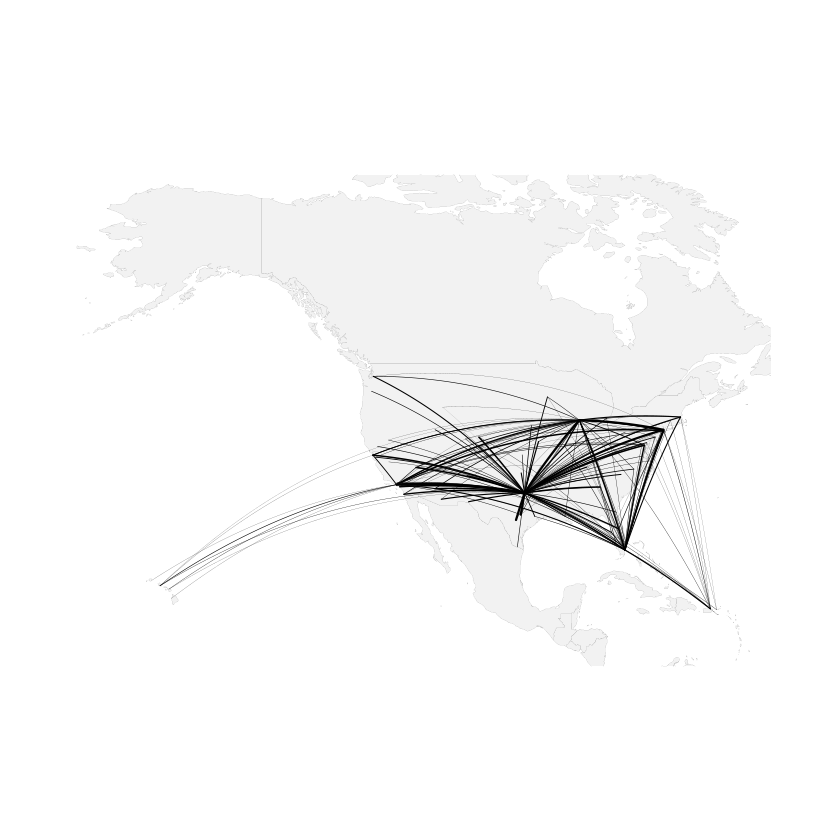

In [4]:
# Draw world map in plain R 
map("world", col="#f2f2f2", fill=TRUE, bg="white", lwd=0.05, xlim=c(-172, -57), ylim=c(12, 72))

# This is needed to compute the great circle between two locations on earth 
library(geosphere)

# Display only American Airlines 
fsub <- flights[flights$airline == "AA",]

# go through EACH flight and FIND the coordinates of originating and destination airport 
for (j in 1:length(fsub$airline)) {
    air1 <- airports[airports$iata == fsub[j,]$airport1,]
    air2 <- airports[airports$iata == fsub[j,]$airport2,]

    # compute the great circle and create a path of 100 points between endpoints 
    inter <- data.frame(gcIntermediate(c(air1[1,]$long, air1[1,]$lat), c(air2[1,]$long, air2[1,]$lat), n=100, addStartEnd=TRUE))
    
    # draw the arc for this flight; line thickness encodes number of flights 
    lines(inter, col="black", lwd=2*fsub[j,]$cnt/max(fsub$cnt))
}

---

### Maps in ggplot

**We can also read the vector map data from a shapefile**. A shapefile contains geospatial vector data that define geometric shapes of a map and the related attributes. 


Shapefiles can be obtained from online resources such as [US Census Bureau](https://www.census.gov/programs-surveys/geography/geographies/mapping-files.html). 


We can **read the shapefiles and convert them to data frames** that **ggplot** can display. But they can be very large and take some time to process. The following shows how to draw the vector maps given in shapefile format using ggplot. 

In [5]:
# load the shapefile and convert to a data frame ggplot can use. 
us_shp <- readShapePoly("/dsa/data/all_datasets/spatial/cb_2015_us_state_500k.shp")
us_map <- fortify(us_shp)
head(us_map)

Warning message:
“readShapePoly is deprecated; use rgdal::readOGR or sf::st_read”Regions defined for each Polygons


long,lat,order,hole,piece,id,group
<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>
-104.0534,41.17054,1,FALSE,1,0,0.1
-104.0532,41.19560,2,FALSE,1,0,0.1
-104.0532,41.19995,3,FALSE,1,0,0.1
-104.0527,41.27525,4,FALSE,1,0,0.1
-104.0526,41.27802,5,FALSE,1,0,0.1
-104.0525,41.27820,6,FALSE,1,0,0.1


In [6]:
# we can also the rgdal library to read shapefiles.
library(rgdal)
us_shp2 <- readOGR(dsn="/dsa/data/all_datasets/spatial/", layer="cb_2015_us_state_500k", GDAL1_integer64_policy=TRUE)
us_map2 <- fortify(us_shp2)
head(us_map2)

rgdal: version: 1.4-6, (SVN revision 841)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/all_datasets/spatial", layer: "cb_2015_us_state_500k"
with 56 features
It has 9 fields
Integer64 fields read as doubles:  ALAND AWATER 


Regions defined for each Polygons


long,lat,order,hole,piece,id,group
<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>
-104.0534,41.17054,1,FALSE,1,0,0.1
-104.0532,41.19560,2,FALSE,1,0,0.1
-104.0532,41.19995,3,FALSE,1,0,0.1
-104.0527,41.27525,4,FALSE,1,0,0.1
-104.0526,41.27802,5,FALSE,1,0,0.1
-104.0525,41.27820,6,FALSE,1,0,0.1


There are **two geoms** we can use to draw a vector map: `geom_path` and `geom_polygon`. A polygon is simply a filled path. The following draws the map using the `geom_path()` geom and sets the projection to Mercator. We also limit the map to particular coordinates using `xlim` and `ylim` for longitudes and lattidues, respectively. 

Warning message:
“Removed 10557 rows containing missing values (geom_path).”

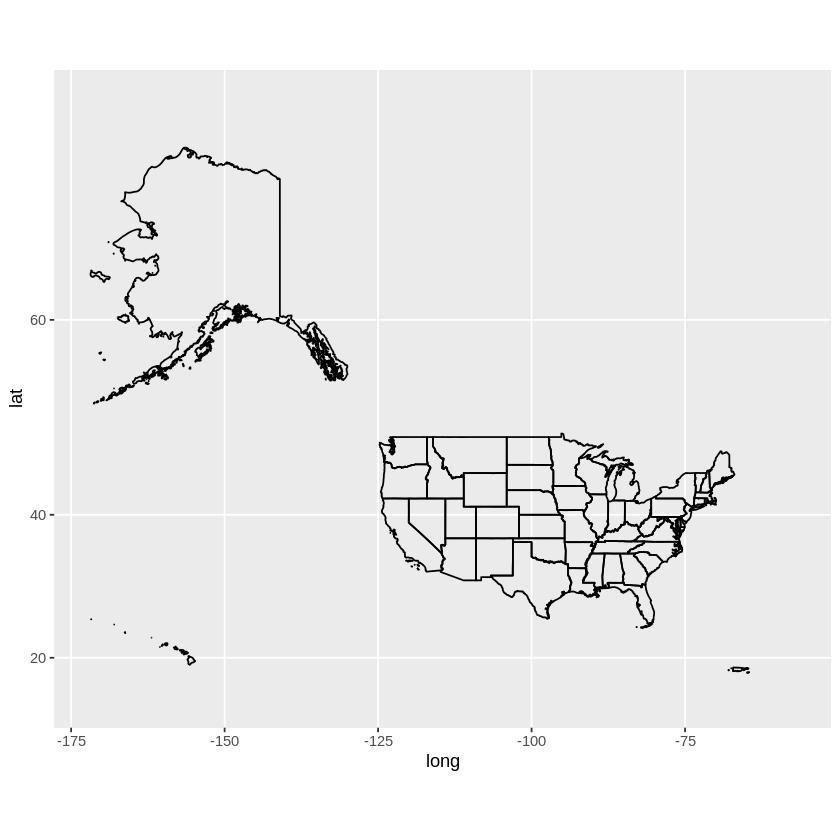

In [7]:
# draw the map 
ggplot(us_map, aes(x=long, y=lat, group=group)) + 
geom_path() + 
coord_map("mercator") + 
xlim(c(-172, -57)) + ylim(c(12, 72)) 

Warning message:
“Removed 10557 rows containing missing values (geom_path).”

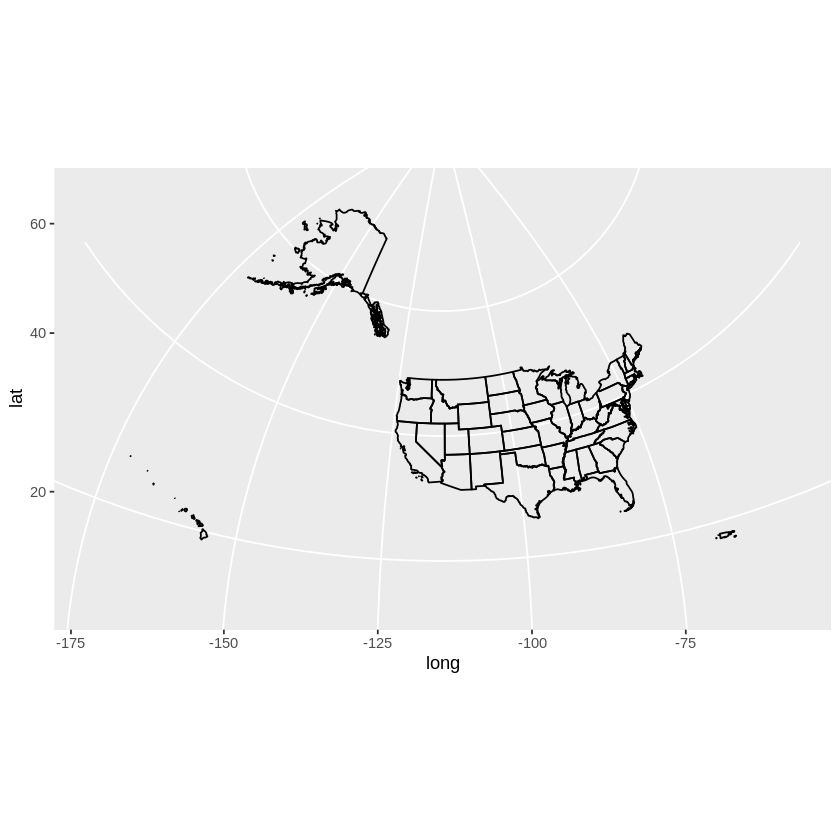

In [7]:
ggplot(us_map, aes(x=long, y=lat, group=group)) + 
geom_path() + 
coord_map("polyconic") +        # use different projection 
xlim(c(-172, -57)) + ylim(c(12, 72)) 

With a `geom_polygon`, we can set the color to fill the polygons. Later, we will make it a visual variable! 

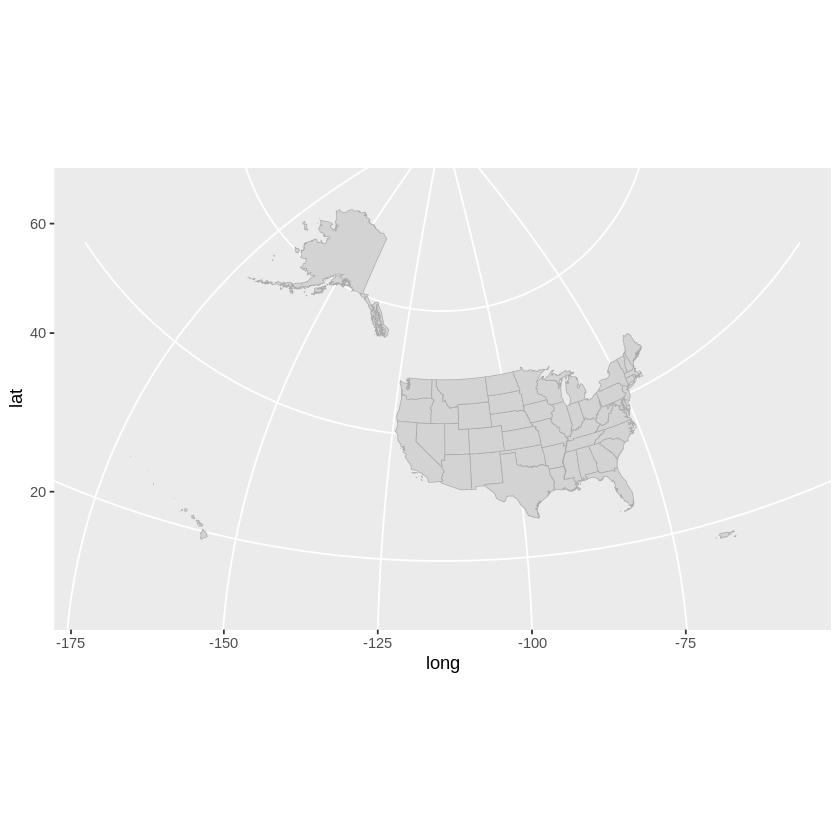

In [8]:
ggplot(us_map, aes(x=long, y=lat, group=group)) + 
geom_polygon(fill="lightgray", color="darkgray", size=0.2) + 
coord_map("polyconic") + 
xlim(c(-172, -57)) + ylim(c(12, 72)) 

**Let's see how to get the vector data using map_data() function of the `maps` library. It will be faster, and we will use this method to get vector map data for our maps.** 

In [10]:
world <- map_data("world")

head(world)

long,lat,group,order,region,subregion
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
-69.89912,12.45200,1,1,Aruba,NA
-69.89571,12.42300,1,2,Aruba,NA
-69.94219,12.43853,1,3,Aruba,NA
-70.00415,12.50049,1,4,Aruba,NA
-70.06612,12.54697,1,5,Aruba,NA
-70.05088,12.59707,1,6,Aruba,NA


In the data frame, `long` and `lat` are the coordinates of the corners of each polygon; `group` provides a unique identifier for contiguous areas within a region, and `region` stands for countries. 

If we plot this data using `geom_point`, we will see the points representing coordinates of each corner of the polygons: 

Warning message:
“Removed 83452 rows containing missing values (geom_point).”

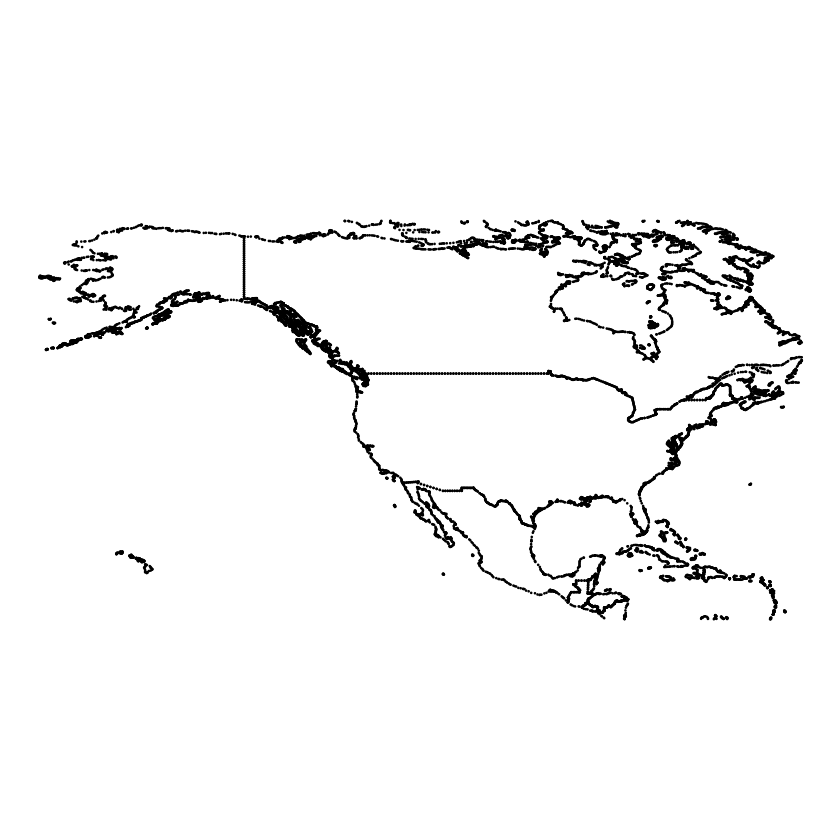

In [11]:
w <- ggplot() + 
     geom_point(data=world, aes(x=long, y=lat), size=0.1)+
     coord_equal() +
     xlim(c(-172, -57)) + ylim(c(12, 72))  + # limit to US 
     theme_void() 
w

Using `geom_polygon`, we will see the polygons as lines drawn between corner points following the order and grouping in the map data. 

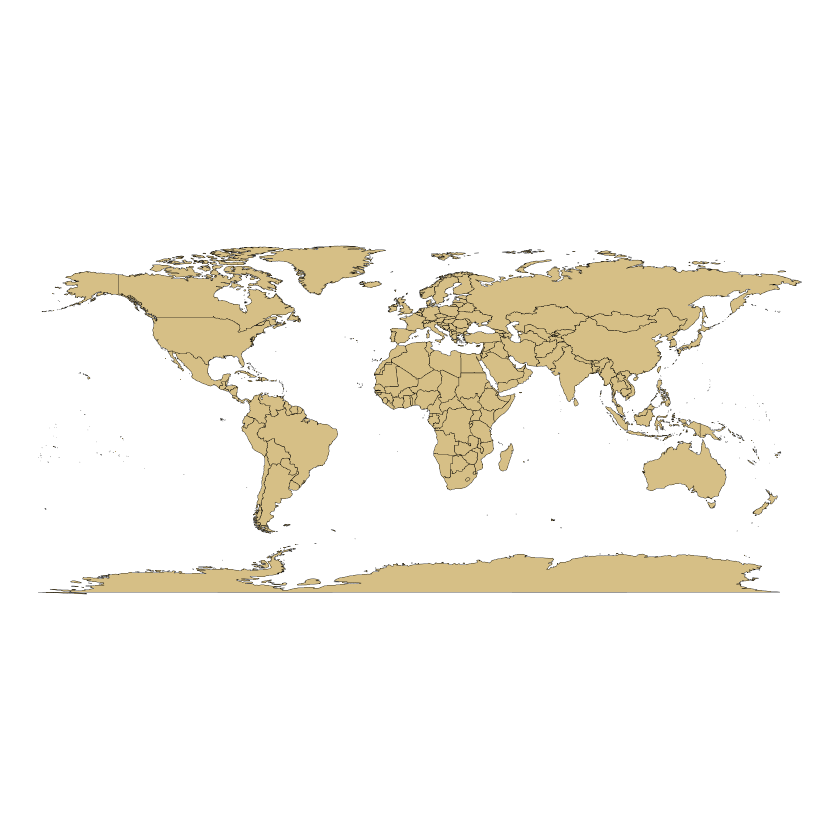

In [12]:
w <- ggplot()
w <- w + geom_polygon(data=world, aes(x=long, y=lat, group=group), color="black", fill="#d6bf86", size=0.1)
w <- w + coord_equal() 
w <- w + theme_void()
w

This is what happens **without** grouping. 

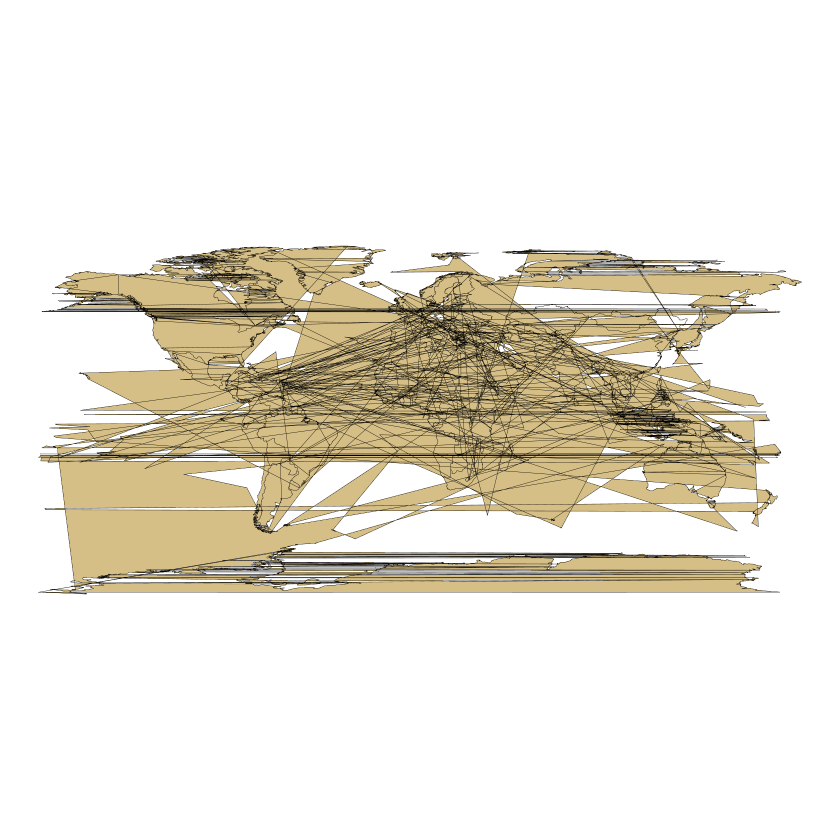

In [13]:
w <- ggplot()
w <- w + geom_polygon(data=world, aes(x=long, y=lat), color="black", fill="#d6bf86", size=0.1)
w <- w + coord_equal() 
w <- w + theme_void()
w

### YOUR TURN: 
**Create a world map where each country is colored separately.**

Now, the fill has to be in aes. Which variable would you use for the fill aesthetic? 



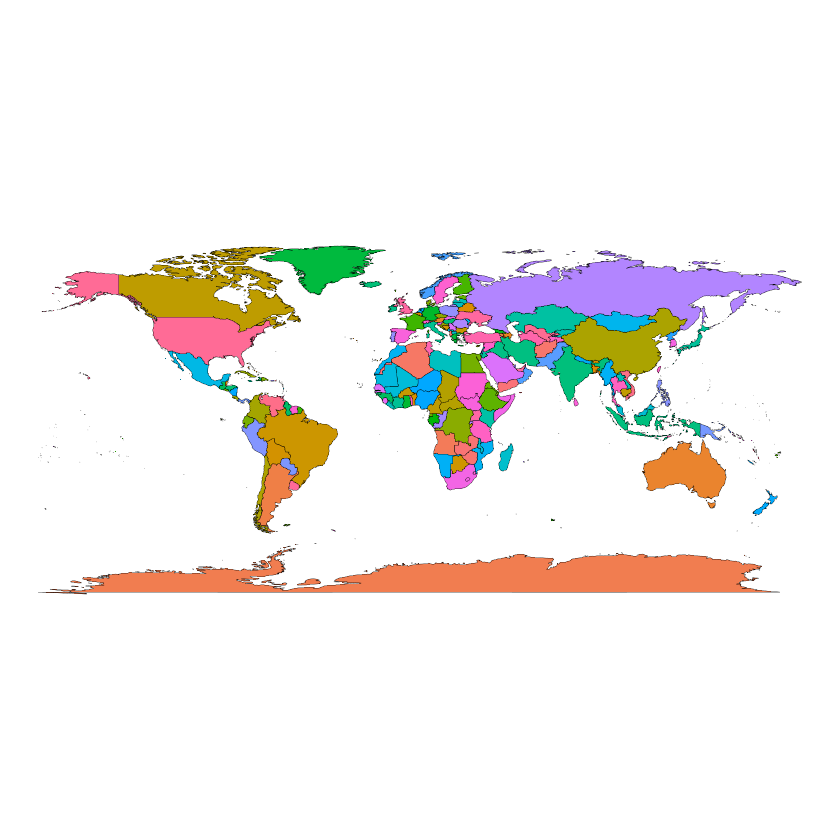

In [14]:
ww <- ggplot()
ww <- ww + geom_polygon(data=world, aes(x=long, y=lat, group=group, fill = region), color="black", size=0.1)
ww <- ww + coord_equal() 
ww <- ww + theme_void() + theme(legend.position = 'None')
ww

---

Similar to the world map, we can also get the US map data with state boundaries. 

In [15]:
us <- map_data("state")

head(us)

long,lat,group,order,region,subregion
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
-87.46201,30.38968,1,1,alabama,NA
-87.48493,30.37249,1,2,alabama,NA
-87.52503,30.37249,1,3,alabama,NA
-87.53076,30.33239,1,4,alabama,NA
-87.57087,30.32665,1,5,alabama,NA
-87.58806,30.32665,1,6,alabama,NA


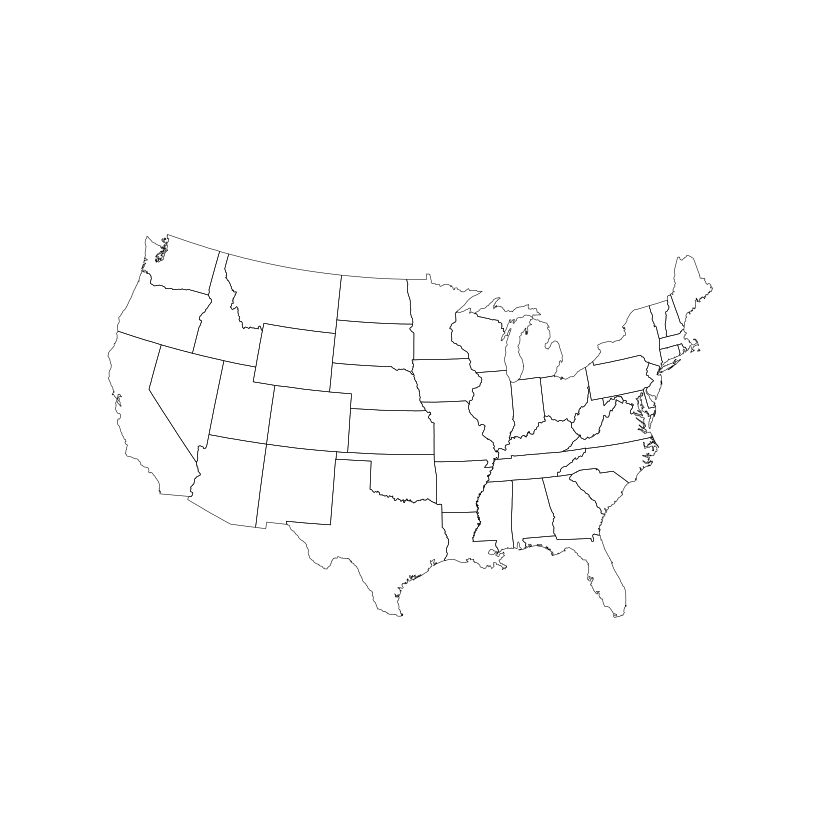

In [16]:
gg <- ggplot() + 
      geom_polygon(data=us, aes(x=long, y=lat, group=group), color="black", fill=NA, size=0.15) +

    # this is a good projection for US
      coord_map("polyconic") +
      theme_void() 
gg 

There is a **special geom just for this type of map data** called `geom_map` which assumes the data frame has `long`, `lat`, and `group` columns, so we don't need to define them in aes. We will see later that it is also useful for other purposes. Sometimes, using `geom_map` can be faster than using `geom_polygon`.

When you use the `geom_map`, make sure to use `expand_limits` or set `xlim` and `ylim` manually. 

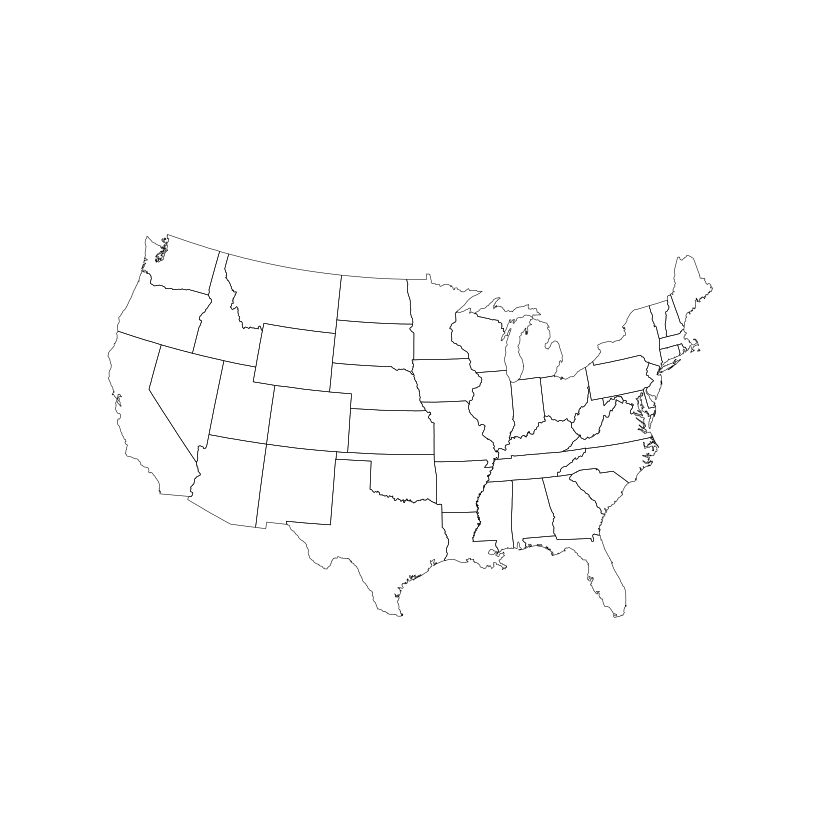

In [17]:
gg <- ggplot(data=us) + 
      geom_map(map=us, aes(map_id=region), color="black", fill=NA, size=0.15) +

# this is a good projection for US
      coord_map("polyconic") +
      expand_limits(x=us$long, y=us$lat) +
      theme_void() 
gg 

We can add some color and change the projection like this: 

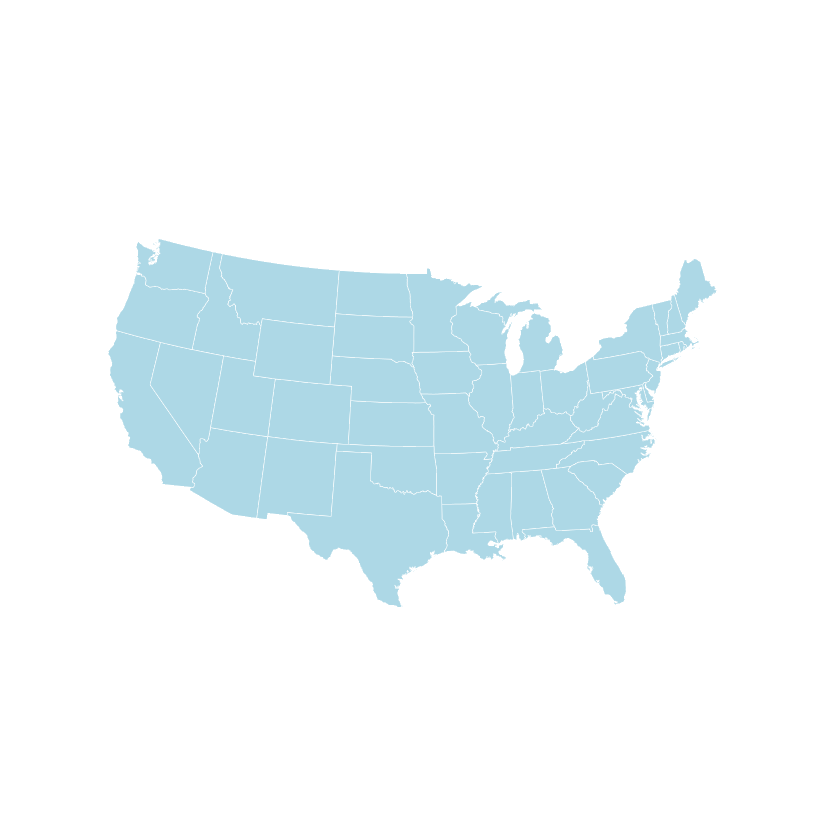

In [18]:
gg <- ggplot(data=us) + 
      geom_map(map=us, aes(map_id=region), color="white", fill="lightblue", size=0.15) + 

#This is better projection
      coord_map("albers", lat0=30, lat1=40) + 
      expand_limits(x=us$long, y=us$lat) +
      theme_void() 
gg

The following shows how we can get data for different levels of detail and use **multiple layers** to overlay them. 

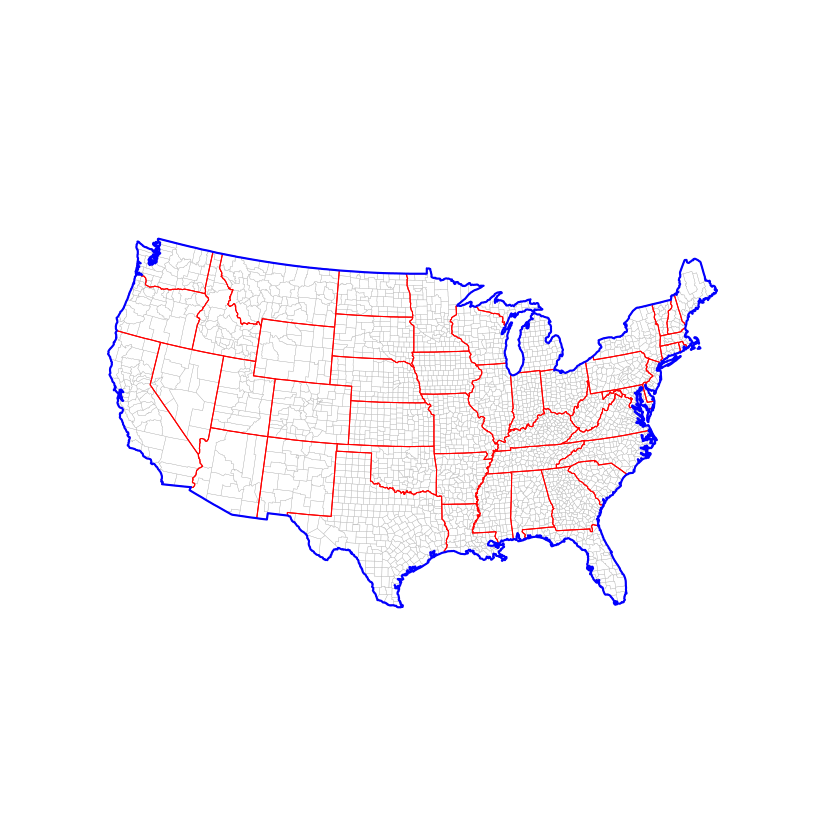

In [19]:
state <- map_data("state")
county <- map_data("county")
usa <- map_data("usa")

gg <- ggplot() +
      geom_map(data=county, map=county, aes(map_id=region), color="grey", fill=NA, size=0.1) + 

      geom_map(data=state, map=state, aes(map_id=region), color="red", fill=NA, size=0.3) +

      geom_map(data=usa, map=usa, aes(map_id=region), color="blue", fill=NA, size=0.6) + 

      coord_map("albers", lat0=30, lat1=40) + 
      expand_limits(x=usa$long, y=usa$lat) +
      theme_void()
gg

Take a look at the county map data: we can pick counties for a given state using `region` for subsetting.

In [20]:
head(county)

long,lat,group,order,region,subregion
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
-86.50517,32.34920,1,1,alabama,autauga
-86.53382,32.35493,1,2,alabama,autauga
-86.54527,32.36639,1,3,alabama,autauga
-86.55673,32.37785,1,4,alabama,autauga
-86.57966,32.38357,1,5,alabama,autauga
-86.59111,32.37785,1,6,alabama,autauga


In [21]:
#Let's pick Missouri
mo <- county[which(county$region=="missouri"),]
head(mo)

,long,lat,group,order,region,subregion
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
43832,-92.67592,40.35342,1450,43832,missouri,adair
43833,-92.33215,40.35342,1450,43833,missouri,adair
43834,-92.33215,40.31331,1450,43834,missouri,adair
43835,-92.33215,40.04402,1450,43835,missouri,adair
43836,-92.84208,40.03829,1450,43836,missouri,adair
43837,-92.84208,40.34769,1450,43837,missouri,adair


Same thing could also be done like this:

In [22]:
mo2 <- map_data("county", "missouri")
head(mo2)

long,lat,group,order,region,subregion
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
-92.67592,40.35342,1,1,missouri,adair
-92.33215,40.35342,1,2,missouri,adair
-92.33215,40.35342,1,3,missouri,adair
-92.33215,40.31331,1,4,missouri,adair
-92.33215,40.04402,1,5,missouri,adair
-92.84208,40.03829,1,6,missouri,adair


Let's select the Boone county from MO. **County names are NOT unique!** There are Boone counties in other states, too, so we will combine Boone and Missouri like this:

In [23]:
boone <- county[which(county$subregion=="boone" & county$region=="missouri"),]

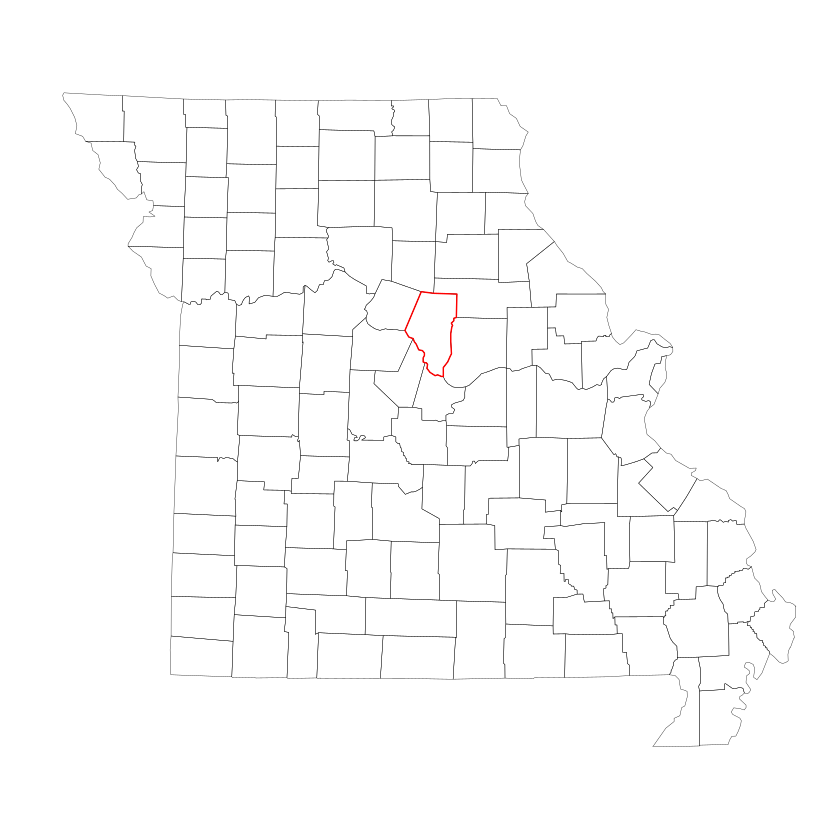

In [24]:
gg <- ggplot() + 
      geom_map(data=mo, map=mo, aes(map_id=region), color="black", fill=NA, size=0.1) + 
      geom_map(data=boone, map=boone, aes(map_id=region), color="red", fill=NA, size=0.4) + 

      coord_map("polyconic") + 
      expand_limits(x=mo$long, y=mo$lat) +
      theme_void()
gg

### YOUR TURN:

**Plot the same map as above with neighbor counties of Boone county colored blue**. (Neighbors are Audrain, Callaway, Cole, Cooper, Howard, Moniteau, Randolph counties).

In [ ]:
< YOUR CODE HERE >


---

**Let's get coordinates of some of the cities in MO and display them.** 


In [ ]:
# this data frame has all the info we need
head(us.cities)

In [ ]:
mo_cities <- subset(us.cities, country.etc=="MO")
mo_cities

In [ ]:
# This is a bubble map overlayed on the previous map we created 
gg + geom_point(data=mo_cities, aes(x=long, y=lat, size=pop, color=factor(capital))) +
scale_color_manual(values=c("blue","red"))

---

**Now, let's finish with a similar plot like in the beginning for the airline routes**, but this time using `ggplot` and `dplyr` for smarter data manipulation. 

Study the following code cells to understand how the map is constructed.

In [25]:
# pick only busy routes 
flights <- subset(flights, cnt>300)

# get airport locations
airport_locs <- airports[, c("iata","long", "lat")]

In [26]:
library(dplyr)

# Link airport lat long to origin and destination

OD <- left_join(flights, airport_locs, by=c("airport1"="iata"))
OD <- left_join(OD, airport_locs, by=c("airport2"="iata"))
head(OD)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



airline,airport1,airport2,cnt,long.x,lat.x,long.y,lat.y
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
AA,MSP,DFW,326,-93.21692,44.88055,-97.03720,32.89595
AA,LGA,ORD,860,-73.87261,40.77724,-87.90446,41.97960
AA,PHX,DFW,550,-112.00806,33.43417,-97.03720,32.89595
AA,ORD,LAX,496,-87.90446,41.97960,-118.40807,33.94254
AA,ORD,DFW,825,-87.90446,41.97960,-97.03720,32.89595
AA,DEN,DFW,558,-104.66700,39.85841,-97.03720,32.89595


Warning message:
“Removed 4 rows containing missing values (geom_curve).”

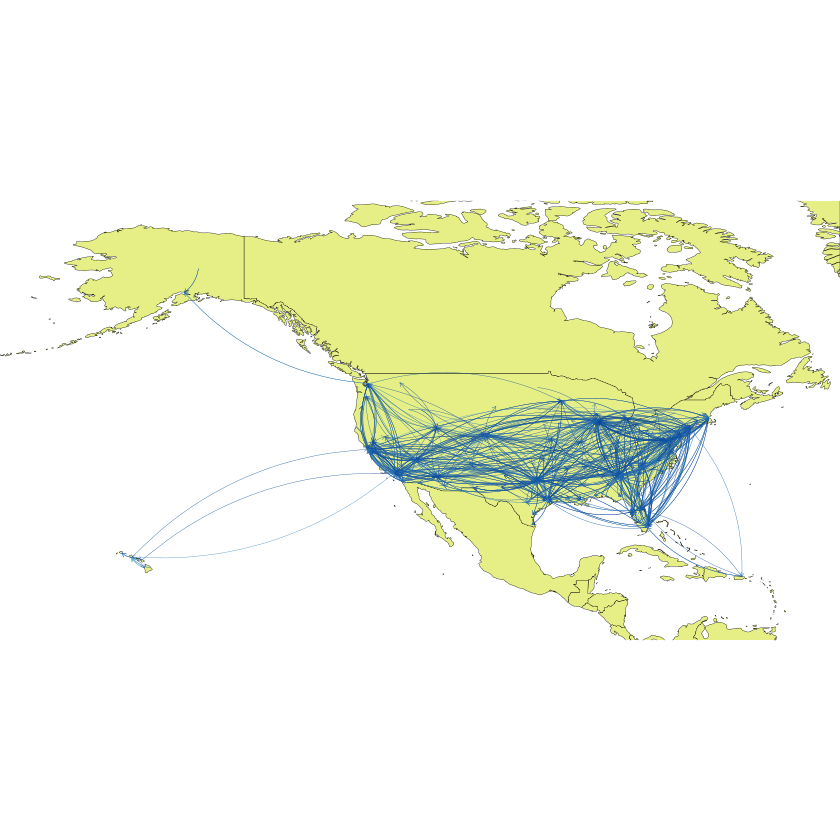

In [27]:
# Now, create curves on the map with a fixed curvature - no great circle computation 
ggplot() + 

geom_map(data=world,map=world, aes(map_id=region), fill="#e6ef86", color="black", size=0.1) +

geom_curve(data=OD, aes(x=long.x, y=lat.x, xend=long.y, yend=lat.y, color=cnt), size=0.1,
                 curvature=-0.2, arrow=arrow(length=unit(0.01, "npc"))) +
    
scale_colour_distiller(palette="Blues", guide="none") +

coord_equal() +

xlim(c(-172,-57)) + ylim(c(12,72)) + 

theme_void()

### YOUR TURN: 

Use the above code and modify it to display only the contiguous United States and add state boundaries (Hint: change the map to one of the earlier maps we have used and play with xlim and ylim).

In [ ]:
< YOUR CODE HERE > 
